In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras import datasets, layers, models
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
!rm -rf ./covid/
!rm -rf ./__MACOSX/
!rm -tf ./dataset.zip

rm: invalid option -- 't'
Try 'rm --help' for more information.


In [3]:
!wget https://www.dropbox.com/s/hg42u5y0nsgliw5/dataset%202.zip?dl=0 -O dataset.zip
!unzip dataset.zip


--2020-05-10 21:51:42--  https://www.dropbox.com/s/hg42u5y0nsgliw5/dataset%202.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hg42u5y0nsgliw5/dataset%202.zip [following]
--2020-05-10 21:51:43--  https://www.dropbox.com/s/raw/hg42u5y0nsgliw5/dataset%202.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadbf676d0a776cad8579c1839d.dl.dropboxusercontent.com/cd/0/inline/A3dUKBeMBaCa-5ANjP01-aFwwh0bXwlilKUQAUD6C6z4hUy7LiWAS0FxqiFUkqZzeTcrjpwT2mFYqfP6OC5ksv7zJSPvS8A5ti5TGjvUJnvgrSw053NJdn8N2iAGxMjox4c/file# [following]
--2020-05-10 21:51:43--  https://ucadbf676d0a776cad8579c1839d.dl.dropboxusercontent.com/cd/0/inline/A3dUKBeMBaCa-5ANjP01-aFwwh0bXwlilKUQAUD6C6z4hUy7LiWAS0FxqiFUkqZzeTcrjpwT2mFYqfP6OC5ksv7zJSPvS8A5ti5

In [0]:
!rm -rf dataset/other\ viral/

## Initialization

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [11]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset/"))
data = []
labels = []

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	data.append(image)
	labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)
print(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
print(testY)


trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

[INFO] loading images...
['other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other pneumonia' 'other pneumonia' 'other pneumonia'
 'other pneumonia' 'other 

## CNN

In [0]:
def set_model():
  model = models.Sequential()
  model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.AveragePooling2D(pool_size=(4, 4)))
  model.add(layers.Flatten(name="flatten"))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(3, activation="softmax"))
  return model

In [0]:
def run_cnn(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)

	predIdxs = np.argmax(predIdxs, axis=1)
	print(testY.argmax(axis=1))
	print(predIdxs)
	print(lb.classes_)

	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))

	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total

	print(cm)
	print("acc: {:.4f}".format(acc))
 
	return acc;

In [0]:
X = data
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    model = set_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_cnn(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
22/22 [==============================] - 62s 3s/step - loss: 0.6503 - accuracy: 0.3750 - val_loss: 0.6223 - val_accuracy: 0.5778
Epoch 2/25
22/22 [==============================] - 62s 3s/step - loss: 0.5770 - accuracy: 0.5233 - val_loss: 0.4652 - val_accuracy: 0.6000
Epoch 3/25
22/22 [==============================] - 61s 3s/step - loss: 0.4904 - accuracy: 0.6105 - val_loss: 0.4466 - val_accuracy: 0.6000
Epoch 4/25
22/22 [==============================] - 61s 3s/step - loss: 0.4494 - accuracy: 0.6279 - val_loss: 0.3685 - val_accuracy: 0.6222
Epoch 5/25
22/22 [==============================] - 61s 3s/step - loss: 0.4167 - accuracy: 0.6570 - val_loss: 0.3678 - val_accuracy: 0.7556
Epoch 6/25
22/22 [==============================] - 62s 3s/step - loss: 0.3918 - accuracy: 0.6453 - val_loss: 0.3381 - val_accuracy: 0.7111
Epoch 7/25
22/22 [==============================] - 63s 3s/step - loss: 0.2996 - accuracy: 0.7791 - val_loss: 

## VGG16 (transfer learning)

In [0]:
def set_vgg_model():
	baseModel = VGG16(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(3, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_vgg(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)

	predIdxs = np.argmax(predIdxs, axis=1)
	print(testY.argmax(axis=1))
	print(predIdxs)
	print(lb.classes_)
 
	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))

	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
	sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
	specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

	print(cm)
	print("acc: {:.4f}".format(acc))
	print("sensitivity: {:.4f}".format(sensitivity))
	print("specificity: {:.4f}".format(specificity))

	N = EPOCHS
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy on COVID-19 Dataset")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	return acc

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
22/22 [==============================] - 70s 3s/step - loss: 0.6497 - accuracy: 0.3864 - val_loss: 0.5928 - val_accuracy: 0.6000
Epoch 2/25
22/22 [==============================] - 69s 3s/step - loss: 0.5963 - accuracy: 0.4593 - val_loss: 0.5490 - val_accuracy: 0.6222
Epoch 3/25
22/22 [==============================] - 68s 3s/step - loss: 0.5500 - accuracy: 0.6047 - val_loss: 0.4993 - val_accuracy: 0.8444
Epoch 4/25
22/22 [==============================] - 72s 3s/step - loss: 0.5136 - accuracy: 0.6802 - val_loss: 0.4658 - val_accuracy: 0.7778
Epoch 5/25
22/22 [==============================] - 67s 3s/step - loss: 0.4836 - accuracy: 0.6919 - val_loss: 0.4411 - val_accuracy: 0.8667
Epoch 6/25
22/22 [==============================] - 67s 3s/step - loss: 0.4581 - accuracy: 0.6977 - val_loss: 0.3999 - val_accuracy: 0.8667
Epoch 7/25
22/22 [==============================] - 67s 3s/step - loss: 0.4340 - accuracy: 0.7384 - val_loss: 

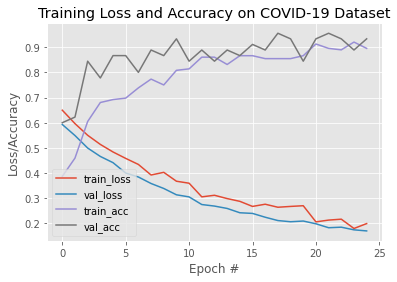

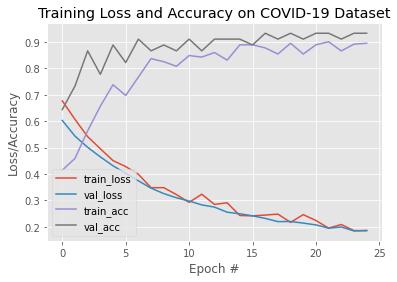

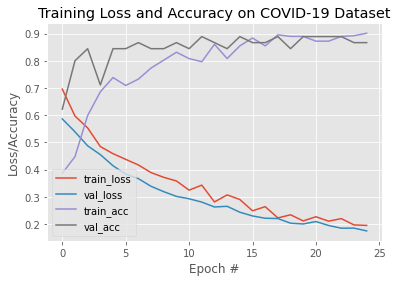

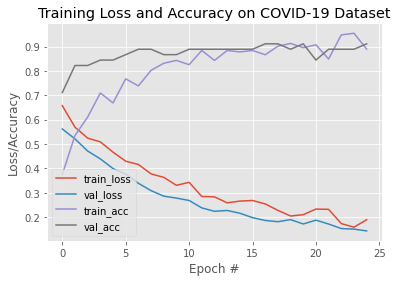

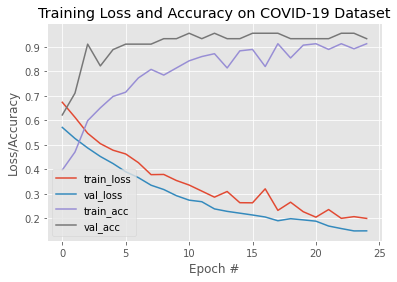

In [14]:
X = data
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    model = set_vgg_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_vgg(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

# VGG 16 (no tansfer)

In [0]:
baseModel = VGG16(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 296s 15s/step - loss: 0.6932 - accuracy: 0.4062 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.6000 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 3/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4563 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 4/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 5/25
20/20 [==============================] - 294s 15s/step - loss: 0.6931 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 6/25
20/20 [==============================] - 293s 15s/step - loss: 0.6931 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 7/25
20/20 [==============================] - 293s 15s/step - loss: 0.69

# ResNet101 (transfer learning)

In [0]:
def set_resnet_model():
	baseModel = ResNet101(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))
	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(3, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_resnet(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)

	predIdxs = np.argmax(predIdxs, axis=1)

	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))

	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total

	print(cm)
	print("acc: {:.4f}".format(acc))
	return acc

In [14]:
X = data
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    model = set_resnet_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_resnet(model, trainX, testX, trainY, testY, trainAug))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
22/22 [==============================] - 62s 3s/step - loss: 0.6804 - accuracy: 0.3580 - val_loss: 0.6234 - val_accuracy: 0.4222
Epoch 2/25
22/22 [==============================] - 60s 3s/step - loss: 0.6369 - accuracy: 0.4593 - val_loss: 0.6274 - val_accuracy: 0.3333
Epoch 3/25
22/22 [==============================] - 59s 3s/step - loss: 0.6465 - accuracy: 0.3547 - val_loss: 0.6130 - val_accuracy: 0.6222
Epoch 4/25
22/22 [==============================] - 59s 3s/step - loss: 0.6193 - accuracy: 0.4070 - val_loss: 0.6050 - val_accuracy: 0.6000
Epoch 5/25
22/22 [==============================] - 59s 3s/step - loss: 0.6151 - accuracy: 0.4244 - val_loss: 0.6016 - val_accuracy: 0.5778
Epoch 6/25
22/22 [==============================] - 59s 3s/step - loss: 0.6036 - accuracy: 0.5000 - val_loss: 0.5968 - val_accuracy: 0.6667
Epoch 7/25
22/22 [==============================] - 59s 3s/step - loss: 0.6051 - accuracy: 0.4477 - val_loss: 

# ResNet101 (no transfer)

In [0]:
baseModel = ResNet101(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 202s 10s/step - loss: 2.1608 - accuracy: 0.6562 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/25
20/20 [==============================] - 201s 10s/step - loss: 1.1539 - accuracy: 0.7063 - val_loss: 0.9232 - val_accuracy: 0.5000
Epoch 3/25
20/20 [==============================] - 198s 10s/step - loss: 0.7781 - accuracy: 0.6438 - val_loss: 0.9201 - val_accuracy: 0.5000
Epoch 4/25
20/20 [==============================] - 197s 10s/step - loss: 0.7304 - accuracy: 0.7375 - val_loss: 0.8302 - val_accuracy: 0.5000
Epoch 5/25
20/20 [==============================] - 193s 10s/step - loss: 0.5768 - accuracy: 0.7437 - val_loss: 0.9875 - val_accuracy: 0.5000
Epoch 6/25
20/20 [==============================] - 199s 10s/step - loss: 0.4764 - accuracy: 0.7812 - val_loss: 1.3723 - val_accuracy: 0.5000
Epoch 7/25
20/20 [==============================] - 197s 10s/step - loss: 0.2505 - accuracy: 0.900

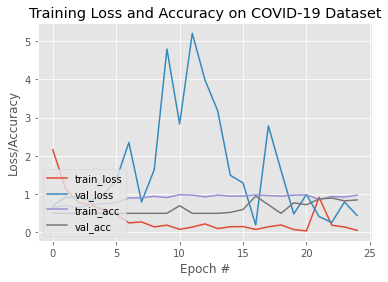

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Data Visualization

In [0]:
metadata_dir = 'covid-chestxray-dataset/metadata.csv'
metadata = pd.read_csv(metadata_dir)
print(metadata.columns)
print(np.shape(metadata))

row , col = np.shape(metadata)
data = []
labels = []

path = 'covid/'
for i in range(row):
  imagePath = 'covid-chestxray-dataset/images/' + metadata.filename[i] 
  image = cv2.imread(imagePath)
  if metadata.finding[i] == 'COVID-19':
    cv2.imwrite(path,image)

In [0]:
print(metadata.finding[41:60], metadata.filename[41:60])

41    COVID-19
42    COVID-19
43    COVID-19
44    COVID-19
45    COVID-19
46    COVID-19
47    COVID-19
48    COVID-19
49    COVID-19
50    COVID-19
51    COVID-19
52    COVID-19
53    COVID-19
54    COVID-19
55    COVID-19
56    COVID-19
57    COVID-19
58        ARDS
59        ARDS
Name: finding, dtype: object 41               1-s2.0-S0929664620300449-gr2_lrg-b.jpg
42               1-s2.0-S0929664620300449-gr2_lrg-c.jpg
43               1-s2.0-S0929664620300449-gr2_lrg-d.jpg
44               1-s2.0-S0929664620300449-gr3_lrg-a.jpg
45               1-s2.0-S0929664620300449-gr3_lrg-b.jpg
46               1-s2.0-S0929664620300449-gr3_lrg-c.jpg
47               1-s2.0-S0929664620300449-gr3_lrg-d.jpg
48                         covid-19-pneumonia-15-PA.jpg
49                          covid-19-pneumonia-15-L.jpg
50                             covid-19-pneumonia-2.jpg
51                          covid-19-pneumonia-7-PA.jpg
52                           covid-19-pneumonia-7-L.jpg
53    radiopae

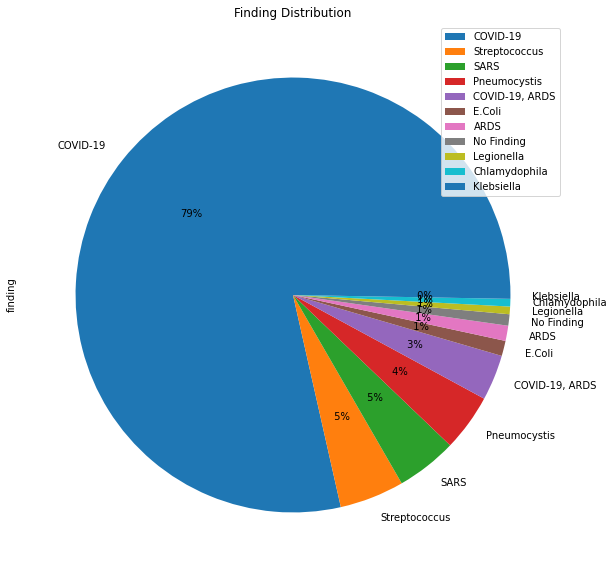

In [0]:
ax = metadata['finding'].value_counts(dropna=False).plot.pie(y='Finding', legend = True, autopct='%2.0f%%', figsize = (10,10), title = 'Finding Distribution')